In [ ]:
import keras
import tensorflow
import h5py
import numpy as np
import chowdhury_s_model_builder
import os

import tensorflow as tf
from keras.api.models import Sequential, Model, load_model
from keras.api.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization, LSTM, Input, GlobalAveragePooling2D
from keras.api.optimizers import Adam
from keras import regularizers
from keras.api.callbacks import ModelCheckpoint, EarlyStopping

from keras.api import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


In [3]:
midv1 = load_model('Mid-Level_Perceptual_Features_Multi-Label Version 1.keras')
for layer in midv1.layers:
    layer.trainable = False
for layer in midv1.layers:
    if layer.trainable:
        print(layer.name)

I0000 00:00:1746342900.912678   22285 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1746342900.914328   22285 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [4]:

# Access and print weights of each layer
for layer in midv1.layers:
    weights = layer.get_weights()
    if weights:  # Check if the layer has weights
        print(f"Layer: {layer.name}")
        for i, weight_array in enumerate(weights):
            print(f"  Weight {i} shape: {weight_array.shape}")
            print(f"  Weights: {weight_array}")

Layer: conv2d
  Weight 0 shape: (5, 5, 1, 64)
  Weights: [[[[-8.75655413e-02 -8.37748125e-02 -1.09311819e-01 ...  1.73202604e-01
     1.90507725e-01  2.06816848e-02]]

  [[ 2.55328923e-01 -1.17324524e-01 -6.44939721e-01 ...  6.90547898e-02
     3.57969224e-01 -6.07791804e-02]]

  [[-1.55293584e-01 -1.64709106e-01 -6.90088347e-02 ... -1.30015584e-02
     1.45543173e-01 -5.28466702e-03]]

  [[ 1.45933861e-02  8.37215781e-02  1.20721031e-02 ... -4.09214422e-02
     1.91999689e-01 -1.76288679e-01]]

  [[-7.16440529e-02  1.10738650e-01  1.20178439e-01 ...  1.11171246e-01
     6.51082918e-02 -1.53367311e-01]]]


 [[[ 4.90793996e-02 -5.10931499e-02 -4.24429700e-02 ...  1.44941092e-01
     9.04776901e-02  2.74432488e-02]]

  [[ 4.55920041e-01 -7.66263716e-03 -1.94650725e-01 ...  5.47087044e-02
     1.48976430e-01 -1.05900347e-01]]

  [[ 3.29224795e-01 -1.86534941e-01 -2.69303974e-02 ... -1.07655749e-01
     1.25120673e-02  2.31121834e-02]]

  [[ 8.47870335e-02 -7.09145516e-02  8.00299633e-04 .

In [5]:
# # Open the HDF5 file in read mode
# with h5py.File("Data/Mid_Level_Linear_Dataset_Data.h5", "r") as hf:
#     mid_level_train_data = hf["train"][:]  # Load the train dataset
#     mid_level_label_data = hf["label"][:]  # Load the label dataset

# print(mid_level_train_data.shape, mid_level_train_data.dtype)  # Check the shape and type
# print(mid_level_label_data.shape, mid_level_label_data.dtype)

In [6]:
# label_counts = np.sum(mid_level_label_data, axis=0)

# # Optional: class names if you have them
# class_names = ["Melodiousness", "Articulation", "Rhythmic Complexity", "Rhythmic Stability",  "Dissonance", "Tonal Stability", "Modality"]

# for i, count in enumerate(label_counts):
#     print(f"{class_names[i] if i < len(class_names) else 'Class ' + str(i)}: {count}")


In [7]:
# Open the HDF5 file in read mode
with h5py.File("Data/Emotify_Data.h5", "r") as hf:
    emotify_train_data = hf["train"][:]  # Load the train dataset
    emotify_label_data = hf["label"][:]  # Load the label dataset

print(emotify_train_data.shape, emotify_train_data.dtype)  # Check the shape and type
print(emotify_label_data.shape, emotify_label_data.dtype)

(400, 256, 1292) float32
(400, 9) int8


In [8]:
# label_counts = np.sum(emotify_label_data, axis=0)

# # Optional: class names if you have them
# class_names = ["Melodiousness", "Articulation", "Rhythmic Complexity", "Rhythmic Stability",  "Dissonance", "Tonal Stability", "Modality"]

# for i, count in enumerate(label_counts):
#     print(f"{class_names[i] if i < len(class_names) else 'Class ' + str(i)}: {count}")


In [9]:
# combined_train = np.concatenate([mid_level_train_data, emotify_train_data], axis=0)
# combined_label = np.concatenate([mid_level_label_data, emotify_label_data], axis=0)

In [10]:
# # Shuffle
# permutation = np.random.permutation(combined_train.shape[0]) # Randomly permute the indices using "5000 + 400"
# shuffled_train = combined_train[permutation]
# shuffled_label = combined_label[permutation]

In [11]:
# # Print final shapes to verify
# print("Shuffled Train Shape:", shuffled_train.shape)
# print("Shuffled Label Shape:", shuffled_label.shape)

In [12]:
# label_counts = np.sum(shuffled_label, axis=0)

# # Optional: class names if you have them
# class_names = ["Melodiousness", "Articulation", "Rhythmic Complexity", "Rhythmic Stability",  "Dissonance", "Tonal Stability", "Modality"]

# for i, count in enumerate(label_counts):
#     print(f"{class_names[i] if i < len(class_names) else 'Class ' + str(i)}: {count}")


In [13]:
# shuffled_train = shuffled_train[..., np.newaxis]  # Add a new axis to the last dimension

In [14]:

# print("Shuffled Train Shape:", shuffled_train.shape)

In [15]:
# shuffled_train.dtype

In [16]:
# mid_level_train_data = mid_level_train_data[..., np.newaxis]

# print(mid_level_train_data.shape, mid_level_train_data.dtype)  # Check the shape and type
# print(mid_level_label_data.shape, mid_level_label_data.dtype)

In [17]:
emotify_train_data = emotify_train_data[..., np.newaxis]

print(emotify_train_data.shape, emotify_train_data.dtype)  # Check the shape and type
print(emotify_label_data.shape, emotify_label_data.dtype)

(400, 256, 1292, 1) float32
(400, 9) int8


In [18]:
# mid_level_input_shape = mid_level_train_data.shape[1], mid_level_train_data.shape[2], mid_level_train_data.shape[3]
# emotify_input_shape = emotify_train_data.shape[1], emotify_train_data.shape[2], emotify_train_data.shape[3]
# print(mid_level_input_shape)
# print(mid_level_input_shape, emotify_input_shape)

In [19]:
# with tensorflow.device('/GPU:0'):
#     input = Input(shape=(256, 1292, 1))
#     x =  Conv2D(64, (5, 5), strides=2, activation="relu", padding="valid")(input)
#     x =  BatchNormalization()(x)   
#     # 2nd Layer
#     x =  Conv2D(64, (3, 3), strides=1, activation="relu", padding="same")(x)
#     x =  BatchNormalization()(x)    
#     # 3rd Layer
#     x =  MaxPooling2D((2, 2))(x)
#     x =  Dropout(0.3)(x)    
#     # 4th Layer
#     x =  Conv2D(128, (3, 3), strides=1, activation="relu", padding="same")(x)
#     x =  BatchNormalization()(x)    
#     # 5th Layer
#     x =  Conv2D(128, (3, 3), strides=1, activation="relu", padding="same")(x)
#     x =  BatchNormalization()(x)    
#     # 6th Layer
#     x =  MaxPooling2D((2, 2))(x)
#     x =  Dropout(0.3)(x)    
#     # 7th Layer
#     x =  Conv2D(256, (3, 3), strides=1, activation="relu", padding="same")(x)
#     x =  BatchNormalization()(x)    
#     # 8th Layer
#     x =  Conv2D(256, (3, 3), strides=1, activation="relu", padding="same")(x)
#     x =  BatchNormalization()(x)    
#     # 9th Layer
#     x =  Conv2D(384, (3, 3), strides=1, activation="relu", padding="same")(x)
#     x =  BatchNormalization()(x)    
#     # 10th Layer
#     x =  Conv2D(512, (3, 3), strides=1, activation="relu", padding="same")(x)
#     x =  BatchNormalization()(x)    
#     # 11th Layer
#     x =  Conv2D(256, (3, 3), strides=1, activation="relu", padding="same")(x)
#     x =  BatchNormalization()(x) 
#     # 12th Layer
#     # x = tfa.layers.AdaptiveAveragePooling2D(x)
#     x =  GlobalAveragePooling2D(keepdims=True)(x)
#     x =  Flatten()(x)
#     x = keras.layers.Dense(256)(x)
#     A2Mid2E_branch = keras.layers.Dense(7, activation="sigmoid")(x)
#     model = Model(inputs=input, outputs=A2Mid2E_branch, name="Mid-Level_Features")
#     model.summary()

In [20]:
x = midv1.output
emotion_layer = Dense(9, activation='sigmoid', name='emotion_dense')(x)

# 3) Build & compile the combined model
emotion_model = Model(inputs=midv1.input, outputs=emotion_layer)
emotion_model.compile(optimizer=Adam(learning_rate=0.0005),
                      loss='binary_crossentropy', metrics=["accuracy"])

In [21]:
for layer in emotion_model.layers:
    if layer.trainable:
        print(layer.name)

emotion_dense


In [22]:
# checkpoint_callback = ModelCheckpoint(
#     filepath="checkpoint_epoch-{epoch:02d}_acc-{accuracy:.4f}_loss-{loss:.4f}.keras",
#     monitor='accuracy',          # Monitor training accuracy
#     mode='max',                   # Save when training accuracy improves
#     save_best_only=True,          # Save only the best model
#     save_weights_only=False,      # Save the entire model
#     verbose=1
# )
# model.compile(optimizer=Adam(learning_rate=0.0005),
#                            loss='binary_crossentropy', metrics=["accuracy"]
#                            )
# model.fit(mid_level_train_data,
#           mid_level_label_data,
#           batch_size=8,
#           epochs=54,
#           initial_epoch=52,
#           callbacks=[checkpoint_callback],
#           shuffle=True, verbose=1)

In [23]:

early_stop = EarlyStopping(
    monitor='loss',       # or 'val_loss' if using validation
    patience=50,          # waits for 50 epochs of no improvement
    restore_best_weights=True,
    verbose=1
)

emotion_model.fit(
    emotify_train_data,
    emotify_label_data,
    batch_size=8,
    epochs=2000,
    shuffle=True,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/2000


I0000 00:00:1746342904.459028   22348 service.cc:152] XLA service 0x7ff6c8008620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746342904.459076   22348 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-05-04 15:15:04.502219: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746342904.842061   22348 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9:43 12s/step - accuracy: 0.0000e+00 - loss: 0.7434

I0000 00:00:1746342915.051629   22348 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.1421 - loss: 0.7301
Epoch 2/2000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.1352 - loss: 0.7185
Epoch 3/2000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.1542 - loss: 0.7067
Epoch 4/2000
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.1590 - loss: 0.6954
Epoch 5/2000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.1304 - loss: 0.6934
Epoch 6/2000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.1606 - loss: 0.6839
Epoch 7/2000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.1631 - loss: 0.6700
Epoch 8/2000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.1454 - loss: 0.6632
Epoch 9/2000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.1395 - loss: 0.6568
Epoch 10/2000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.1367 - loss: 0.6432
Epoch 11/2000
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.1863 - loss: 0.6460
Epoch 12/2000
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/st

In [35]:
emotion_model.save('Emotify_Multi-Label.keras')

In [27]:
W, b = emotion_model.get_layer('emotion_dense').get_weights()
# W.shape == (7,9), b.shape == (9,)
print(W.shape, b.shape)

(7, 9) (9,)


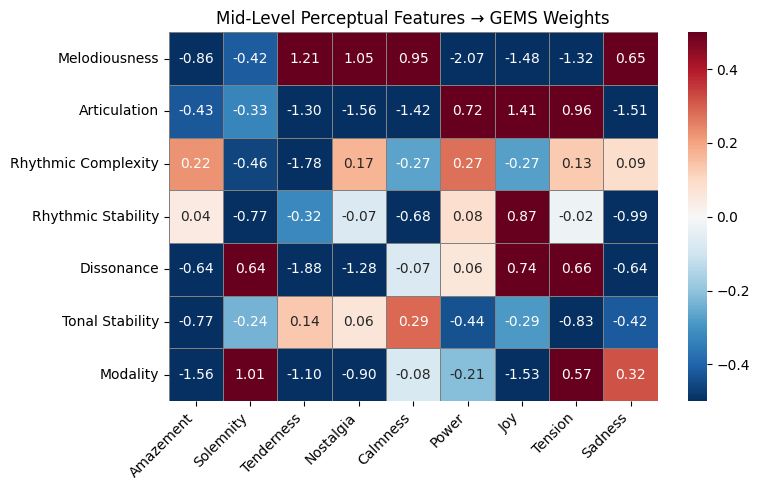

In [34]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

features = ["Melodiousness","Articulation","Rhythmic Complexity","Rhythmic Stability",
            "Dissonance","Tonal Stability","Modality"]
emotions = ["Amazement","Solemnity","Tenderness","Nostalgia","Calmness",
            "Power","Joy","Tension","Sadness"]

df = pd.DataFrame(W, index=features, columns=emotions)

plt.figure(figsize=(8,5))
sns.heatmap(
    df,
    annot=True,
    fmt=".2f",
    center=0,
    cmap="RdBu_r",      # a red–white–blue diverging map
    vmin=-0.5,          # force the lowest weight to map to the darkest blue
    vmax=+0.5,          # force the highest weight to map to the darkest red
    linewidths=0.5,
    linecolor="gray"
)
plt.title("Mid‑Level Perceptual Features → GEMS Weights")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
